### - Canonical Correlation Analysis btw Cell painting & L1000

- This notebook focus on calculating the canonical coefficients between the canonical variables of Cell painting and L1000 level-4 profiles after applying PCA on them.


---------------------------------------------
- The aim of CCA is finding the relationship between two lumped variables in a way that the correlation between these twos is maximum. Obviously, there are several linear combinations of variables, but the aim is to pick only those linear functions which best express the correlations between the two variable sets. These linear functions are called the canonical variables, and the correlations between corresponding pairs of canonical variables are called canonical correlations. [CCA read](https://medium.com/analytics-vidhya/what-is-canonical-correlation-analysis-58ef4349c0b0) [cca_tutorial](https://github.com/google/svcca/blob/master/tutorials/001_Introduction.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import gzip
sns.set_context("talk")
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

In [3]:
###know the current directory
os.getcwd()

'/content'

In [4]:
os.chdir('/content/drive')

In [5]:
# !cat 'My Drive/profiles/cell_painting/cca_core.py'

In [6]:
sys.path.append('My Drive/profiles/cell_painting/')

In [7]:
import cca_core

In [8]:
L1000_cp_dir = 'My Drive/profiles/L1000_cellpainting_comparison/L1000_CP_lvl4_datasets'

In [9]:
df_train = pd.read_csv(os.path.join(L1000_cp_dir, 'train_lvl4_data.csv.gz'), 
                        compression='gzip',low_memory = False)
df_test = pd.read_csv(os.path.join(L1000_cp_dir, 'test_lvl4_data.csv.gz'), 
                        compression='gzip',low_memory = False)

In [10]:
df_targets = pd.read_csv(os.path.join(L1000_cp_dir, 'target_labels.csv'))

In [11]:
metadata_cols = ['replicate_name', 'replicate_id', 'Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_Plate', 
                 'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 'sig_id', 'pert_id', 'pert_idose', 
                 'det_plate', 'det_well', 'Metadata_broad_sample', 'pert_iname', 'moa', 'dose']

In [12]:
target_cols = df_targets.columns[1:]

In [13]:
df_train_y = df_train[target_cols].copy()
df_train_x = df_train.drop(target_cols, axis = 1).copy()

In [14]:
df_test_y = df_test[target_cols].copy()
df_test_x = df_test.drop(target_cols, axis = 1).copy()

In [15]:
df_train_x.drop(metadata_cols, axis = 1, inplace = True)
df_test_x.drop(metadata_cols, axis = 1, inplace = True)

In [16]:
cp_cols = df_train_x.columns.tolist()[:696]
L1000_cols = df_train_x.columns.tolist()[696:]

In [17]:
df_train_cp_x = df_train_x.iloc[:, :696].copy()
df_train_L1000_x = df_train_x.iloc[:, 696:].copy()
df_test_cp_x = df_test_x.iloc[:, :696].copy()
df_test_L1000_x = df_test_x.iloc[:, 696:].copy()

In [18]:
df_cp_x = pd.concat([df_train_cp_x, df_test_cp_x])
df_L1000_x = pd.concat([df_train_L1000_x, df_test_L1000_x])

In [19]:
def normalize(df):
  '''Normalize using Standardscaler'''
  norm_model = StandardScaler()
  df_norm = pd.DataFrame(norm_model.fit_transform(df),index = df.index,columns = df.columns)
  return df_norm

In [20]:
df_L1000_x = normalize(df_L1000_x)
df_cp_x = normalize(df_cp_x)

In [21]:
# taking the first 300 PCs for CCA and SVCCA
def pca_preprocess(df,n_comp1 = 300,feat_new = ['pca'+ str(i) for i in range(300)]):
  pca = PCA(n_components=n_comp1, random_state=42)
  df_pca = pd.DataFrame(pca.fit_transform(df),columns=feat_new)
  return(df_pca)

In [22]:
df_L1_pc_x = pca_preprocess(df_L1000_x)
df_cp_pc_x = pca_preprocess(df_cp_x)

#### - CCA on CP & L1000 train data



In [23]:
cca_results = cca_core.get_cca_similarity(df_cp_pc_x.values.T, df_L1_pc_x.values.T, epsilon=1e-10, verbose=False)

Text(0.5, 1.0, 'CCA correlation coefficients between CP and L1000 canonical variables (300) after PCA')

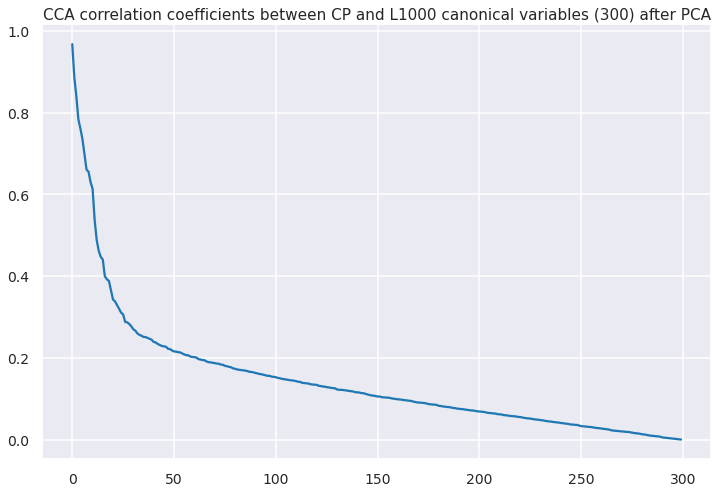

In [24]:
plt.figure(figsize=(12,8))
sns.set_context('talk', font_scale = 0.85)
sns.lineplot(x=range(len(cca_results["cca_coef1"])), y=cca_results["cca_coef1"])
plt.title("CCA correlation coefficients between CP and L1000 canonical variables (300) after PCA")

In [25]:
print("Mean Canonical Correlation co-efficient between CP and L1000 canonical variables (300):", np.mean(cca_results["cca_coef1"]))

Mean Canonical Correlation co-efficient between CP and L1000 canonical variables (300): 0.14511046236358863


#### - (Singular Vectors)CCA as a method to analyze the correlation between Cell painting & L1000

Results using SVCCA keeping 300 dims
mean svcca correlation coefficient: 0.14511046236358852


Text(0.5, 1.0, 'SVCCA correlation coefficients between CP and L1000 canonical variables (300)')

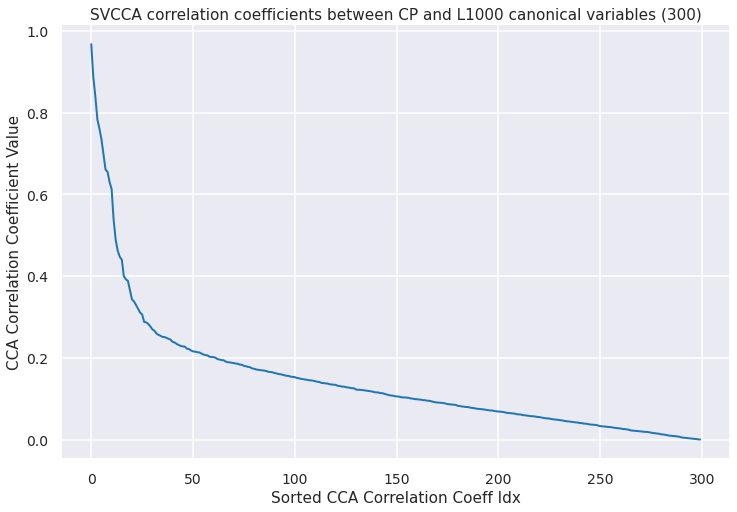

In [26]:
print("Results using SVCCA keeping 300 dims")

# Mean subtract activations
cacts1 = df_cp_pc_x.values.T - np.mean(df_cp_pc_x.values.T, axis=1, keepdims=True)
cacts2 = df_L1_pc_x.values.T - np.mean(df_L1_pc_x.values.T, axis=1, keepdims=True)

# Perform SVD
U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

svacts1 = np.dot(s1[:300]*np.eye(300), V1[:300])
# can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
svacts2 = np.dot(s2[:300]*np.eye(300), V2[:300])
# can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)

print('mean svcca correlation coefficient:', np.mean(svcca_results["cca_coef1"]))
plt.figure(figsize=(12,8))
sns.set_context('talk', font_scale = 0.85)
plt.plot(svcca_results["cca_coef1"], lw=2.0)
plt.xlabel("Sorted CCA Correlation Coeff Idx")
plt.ylabel("CCA Correlation Coefficient Value")
plt.title("SVCCA correlation coefficients between CP and L1000 canonical variables (300)")

### - Using Sklearn CCA package for CCA

In [27]:
cca = CCA(n_components=df_cp_pc_x.shape[1])

In [28]:
cp_cca_vars, L1000_cca_vars = cca.fit_transform(df_cp_pc_x, df_L1_pc_x)

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [30]:
canonical_coeffs = np.corrcoef(cp_cca_vars.T, L1000_cca_vars.T).diagonal(offset=df_cp_pc_x.shape[1])

mean svcca correlation coefficient: 0.14511046236358852


Text(0.5, 1.0, 'CCA correlation coefficients between CP and L1000 canonical variables after PCA')

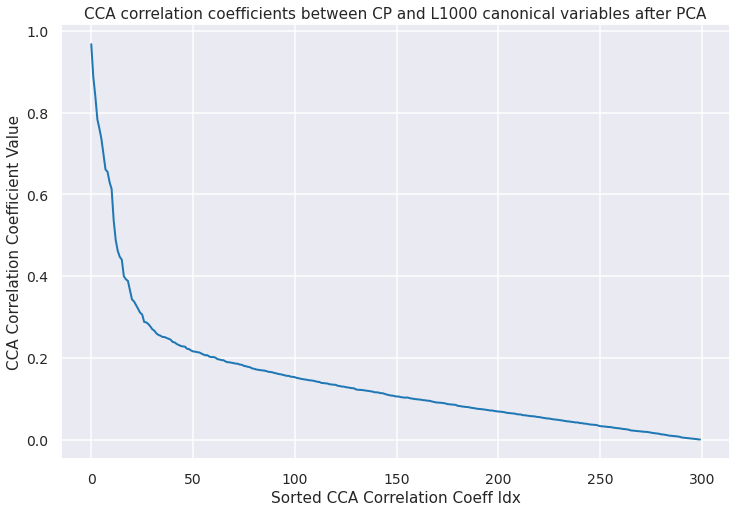

In [31]:
print('mean svcca correlation coefficient:', np.mean(svcca_results["cca_coef1"]))
plt.figure(figsize=(12,8))
sns.set_context('talk', font_scale = 0.85)
plt.plot(canonical_coeffs, lw=2.0)
plt.xlabel("Sorted CCA Correlation Coeff Idx")
plt.ylabel("CCA Correlation Coefficient Value")
plt.title("CCA correlation coefficients between CP and L1000 canonical variables after PCA")

#### - Ultimately for further analysis, focus will be on the first few canonical variables of both CP and L1000 that have the highest canonical coefficients.